In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
class Agent:
    def __init__(self, id, strategy=None, waight=None):
        self.id = id
        self.point_sum = 0
        self.point_last_time = 0
        self.cooporate = True
        self.strategy = ""
        self.define_strategy(strategy=strategy, waight=waight)
    
    def define_strategy(self, strategy=None, waight=None):
        if strategy is None:
            if waight is None:
                waight = [1/4 for _ in range(4)]
            t = np.random.choice(4, p=waight)
            if t == 0:
                self.strategy = "taker"
            elif t == 1:
                self.strategy = "matcher"
            elif t == 2:
                self.strategy = "giver"
            elif t == 3:
                self.strategy = "random"
        else:
            self.strategy = strategy
        
    def __str__(self):
        return str(self.id)

In [79]:
class Simulator:
    def __init__(self, SQR=100, AGENT_NUM=10000, ASSEMBLY_PARAM=np.random.rand()):
        self.agents_lst = [[[] for _ in range(SQR+2)] for _ in range(SQR+2)]
        self.agents_number = AGENT_NUM
        self.sqr_len = SQR
        self.assembly_param = ASSEMBLY_PARAM
        self.potential = None
        self.taker_dist = []
        self.matcher_dist = []
        self.giver_dist = []
        self.random_dist = []
        self.taker_sum_dist = []
        self.matcher_sum_dist = []
        self.giver_sum_dist = []
        self.random_sum_dist = []
        self.agent_dencity_histgram = [np.zeros((SQR+2, SQR+2))]
        self.fitness_of_taker = 0
        self.fitness_of_matcher = 0
        self.fitness_of_giver = 0
        self.fitness_of_random = 0
        self.num_of_taker = []
        self.num_of_matcher = []
        self.num_of_giver = []
        self.num_of_random = []
        self.hist2d_all = []
        self.hist2d_taker = []
        self.hist2d_matcher = []
        self.hist2d_giver = []
        self.hist2d_random = []

        self.cal_potential()
        self.put_init_agents(AGENT_NUM)

    def put_init_agents(self, AGENT_NUM):
        taker_counter, matcher_counter, giver_counter, random_counter = 0,0,0,0
        for n in range(AGENT_NUM):
            t = np.sum(self.potential, axis=1)
            i = np.random.choice(self.sqr_len + 2, p=t/np.sum(t))
            j = np.random.choice(self.sqr_len + 2, p=self.potential[i,:]/np.sum(self.potential[i,:]))
            agent = Agent(n)
            self.agents_lst[i][j].append(agent)
            self.agent_dencity_histgram[0][i,j] += 1
            if agent.strategy == "taker":
                taker_counter += 1
            elif agent.strategy == "matcher":
                matcher_counter += 1
            elif agent.strategy == "giver":
                giver_counter += 1
            elif agent.strategy == "random":
                random_counter += 1
        self.num_of_taker.append(taker_counter)
        self.num_of_matcher.append(matcher_counter)
        self.num_of_giver.append(giver_counter)
        self.num_of_random.append(random_counter)

    def cal_potential(self):
        SQR = self.sqr_len
        self.potential = np.array([[(np.sin(np.pi*i/(SQR+1))*np.sin(np.pi*j/(SQR+1)))**0.5 for i in range(SQR+2)] for j in range(SQR+2)])
        self.potential[-1,:] = 0.0
        self.potential[:,-1] = 0.0

    def move_agents(self):
        new_agents_lst = [[[] for _ in range(self.sqr_len+2)] for _ in range(self.sqr_len+2)]
        SQR = self.sqr_len
        new_agent_dencity_histgram = np.zeros((SQR+2, SQR+2))
        new_hist2d_all, new_hist2d_taker, new_hist2d_matcher, new_hist2d_giver, new_hist2d_random \
            = np.zeros((SQR+2, SQR+2)), np.zeros((SQR+2, SQR+2)), np.zeros((SQR+2, SQR+2)), np.zeros((SQR+2, SQR+2)), np.zeros((SQR+2, SQR+2))
        for i in range(1, SQR+1):
            for j in range(1, SQR+1):
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    w = np.array([
                        [self.potential[i-1,j-1], self.potential[i-1,j], self.potential[i-1,j+1]],
                        [self.potential[i,j-1],   self.potential[i,j],   self.potential[i,j+1]],
                        [self.potential[i+1,j-1], self.potential[i+1,j], self.potential[i+1,j+1]],
                    ])
                    w /= np.sum(w)
                    w2 = self.assembly_param * self.agent_dencity_histgram[-1][i-1:i+2,j-1:j+2] / np.sum(self.agent_dencity_histgram[-1][i-1:i+2,j-1:j+2])
                    w = (w + w2)/np.sum(w+w2)
                    t = np.sum(w, axis=1)
                    ni = i + np.random.choice(3, p=t) - 1
                    nj = j + np.random.choice(3, p=w[ni-i+1,:]/np.sum(w[ni-i+1,:])) - 1
                    new_agents_lst[ni][nj].append(agent)
                    new_agent_dencity_histgram[ni,nj] += 1

                    new_hist2d_all[ni,nj] += 1
                    if agent.strategy == "taker":
                        new_hist2d_taker[i,j] += 1
                    elif agent.strategy == "matcher":
                        new_hist2d_matcher[i,j] += 1
                    elif agent.strategy == "giver":
                        new_hist2d_giver[i,j] += 1
                    elif agent.strategy == "random":
                        new_hist2d_random[i,j] += 1
                        
        self.agents_lst = new_agents_lst
        self.agent_dencity_histgram.append(new_agent_dencity_histgram)
        self.hist2d_all.append(new_hist2d_all)
        self.hist2d_taker.append(new_hist2d_taker)
        self.hist2d_matcher.append(new_hist2d_matcher)
        self.hist2d_giver.append(new_hist2d_giver)
        self.hist2d_random.append(new_hist2d_random)
    
    def compe_and_coop(self):
        SQR = self.sqr_len
        for i in range(1, SQR+1):
            for j in range(1, SQR+1):
                give_n, take_n = 0, 0
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    strategy = agent.strategy
                    if strategy == "taker":
                        take_n += 1
                        agent.cooporate = False
                    elif strategy == "matcher":
                        if agent.point_last_time < 0:
                            take_n += 1
                            agent.cooporate = False
                        else:
                            give_n += 1
                            agent.cooporate = True
                    elif strategy == "giver":
                        give_n += 1
                        agent.cooporate = True
                    elif strategy == "random":
                        if np.random.randint(0,2) == 0:
                            take_n += 1
                            agent.cooporate = False
                        else:
                            give_n += 1
                            agent.cooporate = True
                if len(self.agents_lst[i][j]) > 1:
                    for k in range(len(self.agents_lst[i][j])):
                        agent = self.agents_lst[i][j][k]
                        #   ここ、評価方法を改善する
                        if give_n < take_n:
                            agent.point_last_time = len(self.agents_lst[i][j])**0.25 + (give_n - take_n)*(2*agent.cooporate - 1)
                        else:
                            agent.point_last_time = len(self.agents_lst[i][j])**0.25 + (give_n - take_n)*(2 - 1*agent.cooporate)
                        agent.point_sum += agent.point_last_time
                elif len(self.agents_lst[i][j]) == 1:
                    agent = self.agents_lst[i][j][0]
                    agent.point_last_time = 0.0
    
    def compare_point_distribution_about_strategies(self):
        taker_dist, mathcer_dist, giver_dist, random_dist = [], [], [], []
        taker_sum_dist, mathcer_sum_dist, giver_sum_dist, random_sum_dist = [], [], [], []
        SQR = self.sqr_len
        for i in range(1, SQR+1):
            for j in range(1, SQR+1):
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    strategy = agent.strategy
                    if strategy == "taker":
                        taker_sum_dist.append(agent.point_sum)
                        taker_dist.append(agent.point_last_time)
                    elif strategy == "matcher":
                        mathcer_sum_dist.append(agent.point_sum)
                        mathcer_dist.append(agent.point_last_time)
                    elif strategy == "giver":
                        giver_sum_dist.append(agent.point_sum)
                        giver_dist.append(agent.point_last_time)
                    elif strategy == "random":
                        random_sum_dist.append(agent.point_sum)
                        random_dist.append(agent.point_last_time)
        self.taker_dist.append(taker_dist)
        self.matcher_dist.append(mathcer_dist)
        self.giver_dist.append(giver_dist)
        self.random_dist.append(random_dist)
        self.taker_sum_dist.append(taker_sum_dist)
        self.matcher_sum_dist.append(mathcer_sum_dist)
        self.giver_sum_dist.append(giver_sum_dist)
        self.random_sum_dist.append(random_sum_dist)
    
    def cal_fitness_4_each_strategy(self):
        if self.taker_dist[-1]:
            self.fitness_of_taker = sum(self.taker_dist[-1])/len(self.taker_dist)
        else:
            self.fitness_of_taker = 0
        if self.matcher_dist[-1]:
            self.fitness_of_matcher = sum(self.matcher_dist[-1])/len(self.matcher_dist)
        else:
            self.fitness_of_matcher = 0
        if self.giver_dist[-1]:
            self.fitness_of_giver = sum(self.giver_dist[-1])/len(self.giver_dist)
        else:
            self.fitness_of_giver = 0
        if self.random_dist[-1]:
            self.fitness_of_random = sum(self.random_dist[-1])/len(self.random_dist)
        else:
            self.fitness_of_random = 0

    def part_of_agents_change_strategy(self, STRATEGY_CHANGE_RATE=0.1):
        self.cal_fitness_4_each_strategy()
        t = np.array([self.fitness_of_taker, self.fitness_of_matcher, self.fitness_of_giver, self.fitness_of_random])
        if np.std(t) == 0.0:
            t[:] = 0
        else:
            t = (t - np.mean(t))/np.std(t)
            t += -np.min(t) + 1
        S = np.sum(t)
        A = 1/STRATEGY_CHANGE_RATE
        taker_counter, matcher_counter, giver_counter, random_counter = 0,0,0,0
        for i in range(1, self.sqr_len+1):
            for j in range(1, self.sqr_len+1):
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    if A*S*np.random.rand() < np.sum(t[:1]):
                        agent.strategy = "taker"
                    elif A*S*np.random.rand() < np.sum(t[:2]):
                        agent.strategy = "matcher"
                    elif A*S*np.random.rand() < np.sum(t[:3]):
                        agent.strategy = "giver"
                    elif A*S*np.random.rand() < np.sum(t[:4]):
                        agent.strategy = "randaom"
                    
                    if agent.strategy == "taker":
                        taker_counter += 1
                    elif agent.strategy == "matcher":
                        matcher_counter += 1
                    elif agent.strategy == "giver":
                        giver_counter += 1
                    elif agent.strategy == "random":
                        random_counter += 1

        self.num_of_taker.append(taker_counter)
        self.num_of_matcher.append(matcher_counter)
        self.num_of_giver.append(giver_counter)
        self.num_of_random.append(random_counter)

    def run(self):
        self.move_agents()
        self.compe_and_coop()
        self.compare_point_distribution_about_strategies()
        self.part_of_agents_change_strategy()

    def plot_current_point_histgrams(self):
        fig, ax = plt.subplots(2,2)
        ax[0,0].hist(self.taker_dist[-1])
        ax[0,0].set_title("taker")
        ax[0,1].hist(self.matcher_dist[-1])
        ax[0,1].set_title("matcher")
        ax[1,0].hist(self.giver_dist[-1])
        ax[1,0].set_title("giver")
        ax[1,1].hist(self.random_dist[-1])
        ax[1,1].set_title("random")
        plt.title("current point histgrams for strategy")
        plt.savefig("tmp")
    
    def plot_point_sum_histgrams(self):
        fig, ax = plt.subplots(2,2)
        ax[0,0].hist(self.taker_sum_dist[-1])
        ax[0,0].set_title("taker now")
        ax[0,1].hist(self.matcher_sum_dist[-1])
        ax[0,1].set_title("matcher now")
        ax[1,0].hist(self.giver_sum_dist[-1])
        ax[1,0].set_title("giver now")
        ax[1,1].hist(self.random_sum_dist[-1])
        ax[1,1].set_title("random now")
        plt.title("point sum histgrams for current strategy")
        plt.savefig("tmp")
    
    def plot_transition_number_of_strategy(self):
        plt.plot(self.num_of_taker, label="taker")
        plt.plot(self.num_of_matcher, label="matcher")
        plt.plot(self.num_of_giver, label="giver")
        plt.plot(self.num_of_random, label="random")
        plt.legend()
        plt.title("transition number of strategy")
        plt.savefig("tmp")
    
    def plot_2d_hist_for_strategy(self):
        fig, ax = plt.subplots(3,2)
        sns.heatmap(self.hist2d_taker[-1], ax=ax[0,0])
        ax[0,0].set_title("taker")
        sns.heatmap(self.hist2d_matcher[-1], ax=ax[0,1])
        ax[0,1].set_title("matcher")
        sns.heatmap(self.hist2d_giver[-1], ax=ax[1,0])
        ax[1,0].set_title("giver")
        sns.heatmap(self.hist2d_random[-1], ax=ax[1,1])
        ax[1,1].set_title("random")
        sns.heatmap(self.hist2d_all[-1], ax=ax[2,0])
        ax[2,0].set_title("all")

        plt.title("hist 2d for last time strategy")
        plt.savefig("tmp")


In [80]:
simulator = Simulator()#SQR=5, AGENT_NUM=25)

for r in range(10):
    simulator.run()

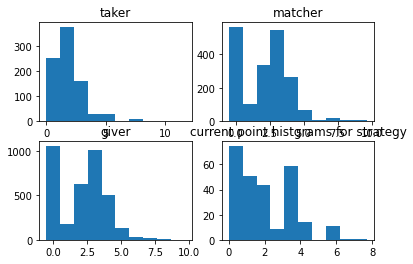

In [81]:
simulator.plot_current_point_histgrams()

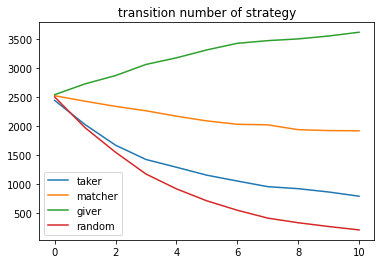

In [82]:
simulator.plot_transition_number_of_strategy()

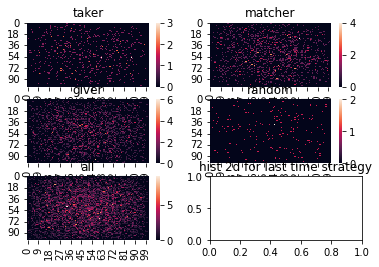

In [83]:
simulator.plot_2d_hist_for_strategy()